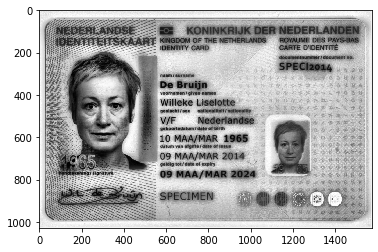

In [26]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_sauvola 
import numpy as np
from skimage.exposure import is_low_contrast
from skimage.exposure import adjust_gamma
from skimage import exposure
from skimage.color import rgb2hsv

cimage = imread('https://upload.wikimedia.org/wikipedia/commons/3/3a/Dutch_identity_card_front_specimen_issued_9_March_2014.jpg') 
img = rgb2gray(cimage)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
plt.imshow(img_adapteq, cmap="gray")

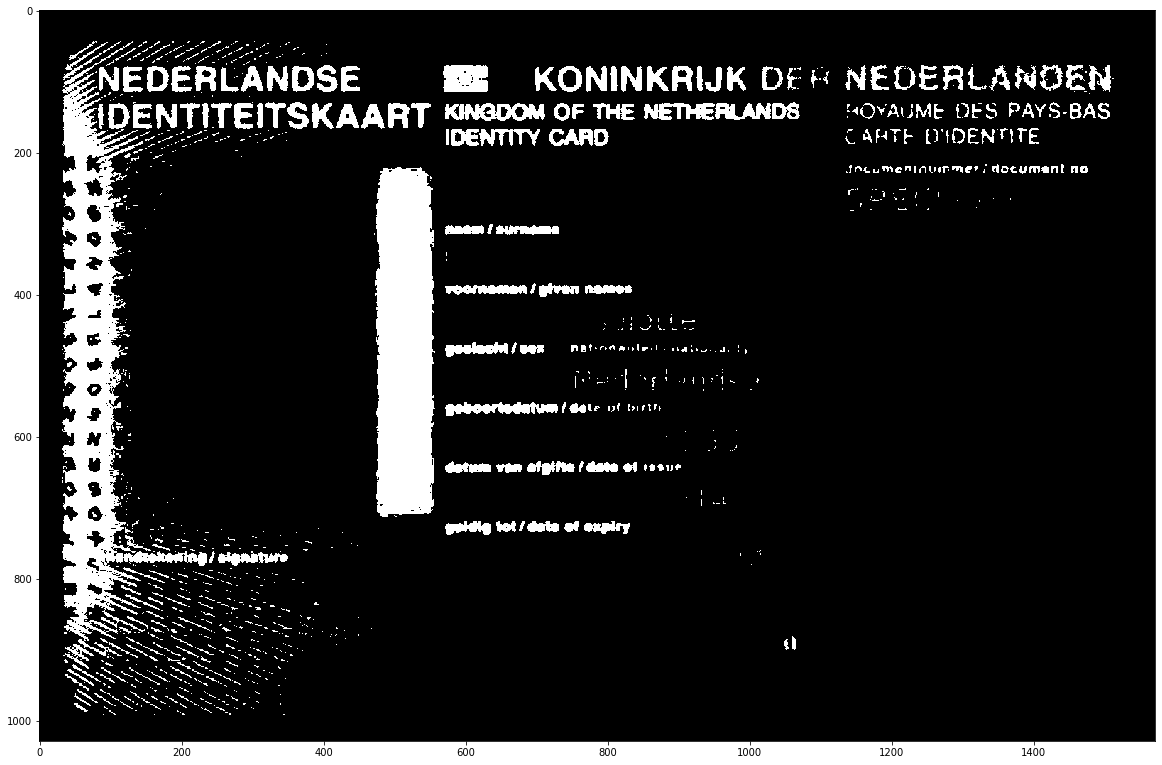

In [34]:
# binarize
from skimage.morphology import binary_closing
from skimage.filters import threshold_otsu

window_size = 3
thresh_sauvola = threshold_otsu(img_eq)
binary_sauvola = img_eq > 0.12
plt.figure(figsize=(20,20))
plt.imshow(binary_sauvola, cmap="gray")

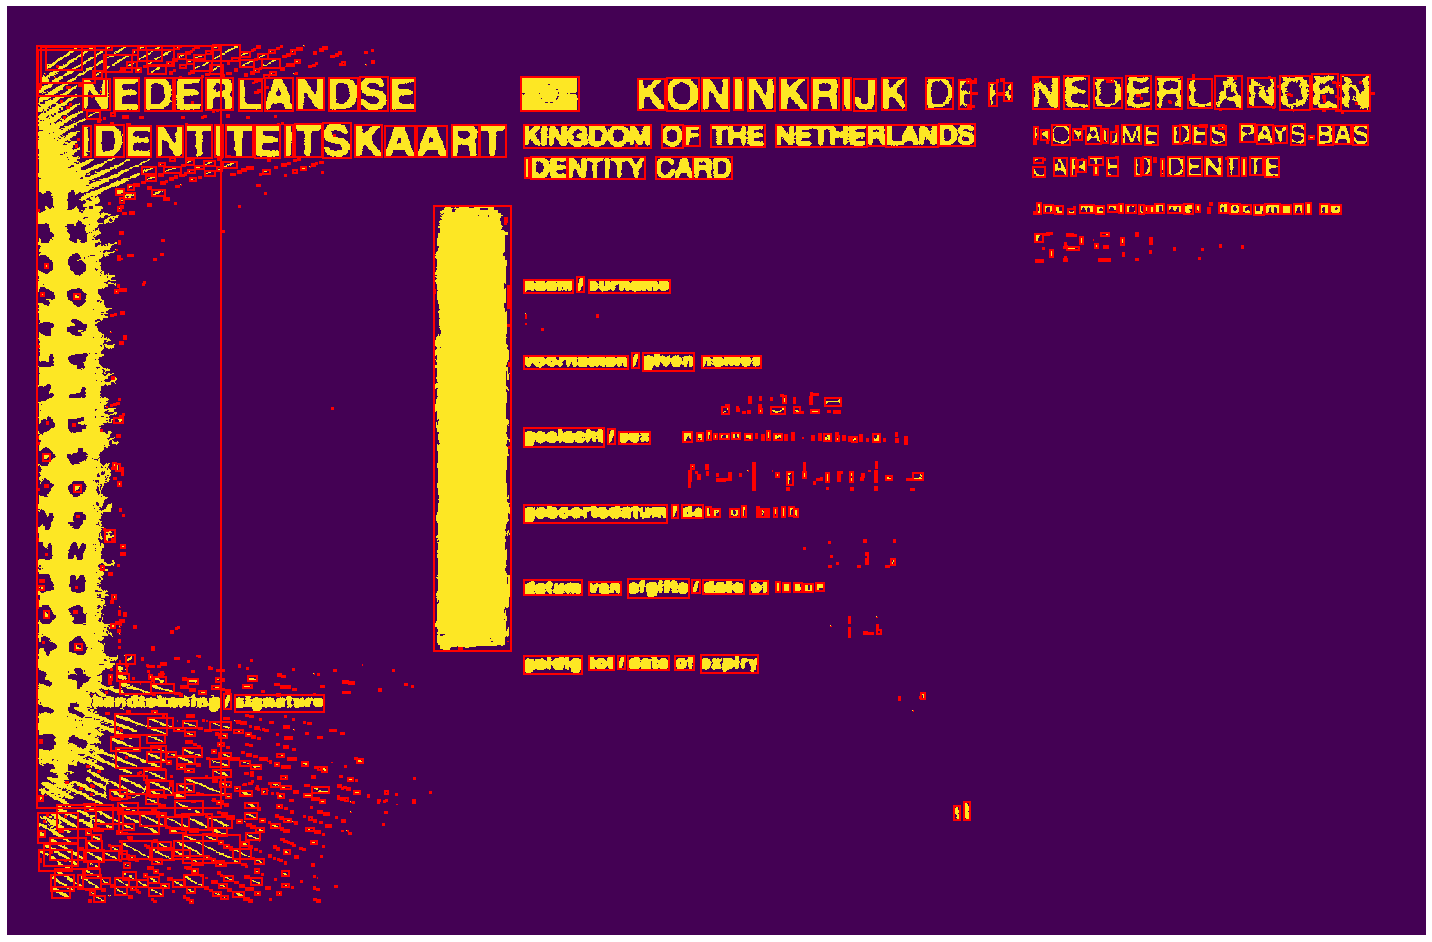

In [35]:
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

label_image = label(binary_sauvola)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(binary_sauvola)

for region in regionprops(label_image):
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [36]:
def is_a_child(root_region, child_region):
    rminr, rminc, rmaxr, rmaxc = root_region.bbox
    minr, minc, maxr, maxc = child_region.bbox
    if minr > rminr and minc > rminc and maxr < rmaxr and maxc < rmaxc:
        return True
    return False

1217
1815


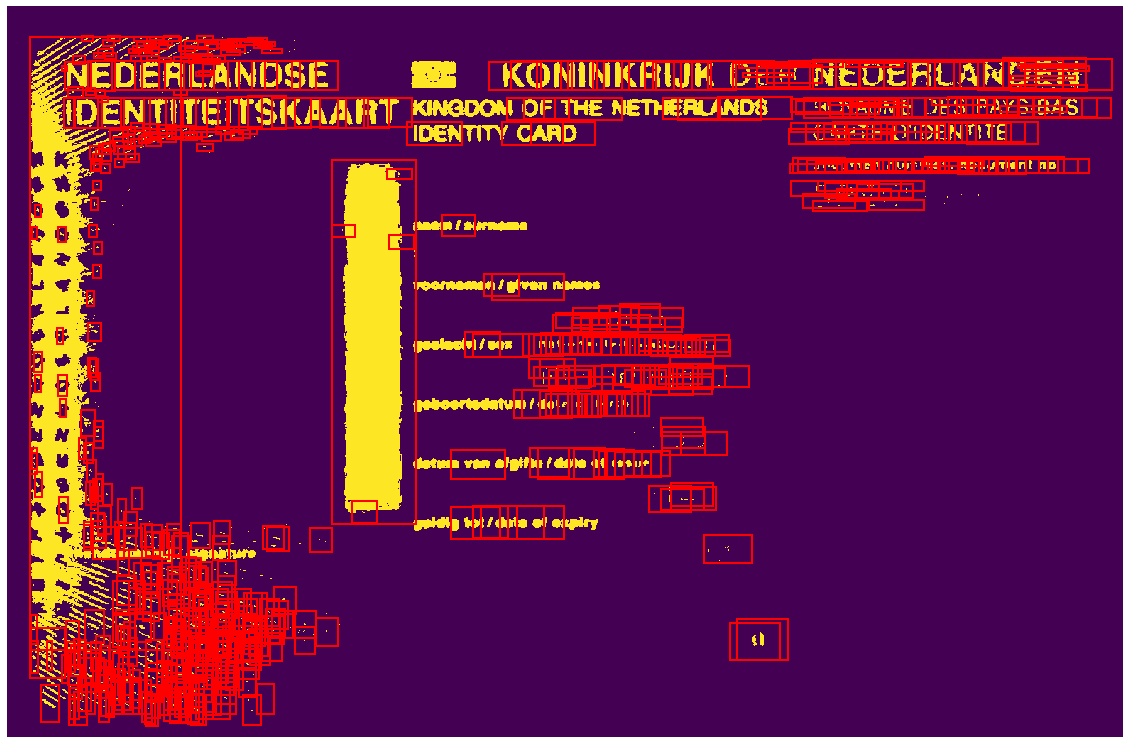

In [37]:
from scipy.ndimage.morphology import distance_transform_edt

region_props = regionprops(label_image)
fig, ax = plt.subplots(figsize=(20, 16))

bounding_boxes = []
print(len(region_props))

img_height, img_weight = binary_sauvola.shape

for index, region in enumerate(region_props):
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    
    aspect_ratio = width/height
    
    should_clean = region.area < 15
    should_clean = region.area > (img_height*img_weight/5)
    should_clean = should_clean or aspect_ratio < 0.06  or aspect_ratio > 3
    should_clean = should_clean or region.eccentricity > 0.995
    should_clean = should_clean or region.solidity < 0.3
    should_clean = should_clean or region.extent < 0.2 or region.extent > 0.9
#     should_clean = should_clean or region.euler_number < -4
    
    strokeWidthValues = distance_transform_edt(region.image)
    strokeWidthMetric = np.std(strokeWidthValues)/np.mean(strokeWidthValues)
    should_clean = should_clean or strokeWidthMetric < 0.4
    
#     if should_clean:
#         for coord in region.coords:
#             cleaned_img[coord[0],coord[1]] = False
    if not should_clean:
        expansionAmountY = 0.02
        expansionAmountX = 0.03
        minr, minc, maxr, maxc = region.bbox
        
        minr = np.floor((1-expansionAmountY) * minr)
        minc = np.floor((1-expansionAmountX) * minc)
        maxr = np.ceil((1+expansionAmountY) * maxr)
        maxc = np.ceil((1+expansionAmountX) * maxc)

        bounding_boxes.append([minr, minc, maxr, maxc])
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)    

#remove ccs which have more than 3 components within them
label_heirarchy = {}
for iindex, iregion  in enumerate(region_props[0:-1]):
    count = 0 
    for jindex, jregion in enumerate(region_props[1:]):
        if is_a_child(iregion, jregion):
            count += 1

    if count < 3:
        minr, minc, maxr, maxc = iregion.bbox
        bounding_boxes.append([minr, minc, maxr, maxc])


ax.set_axis_off()
print(len(bounding_boxes))
ax.imshow(binary_sauvola)
plt.show()

number_of_checks: 704020
time_taken: 8.326965570449829


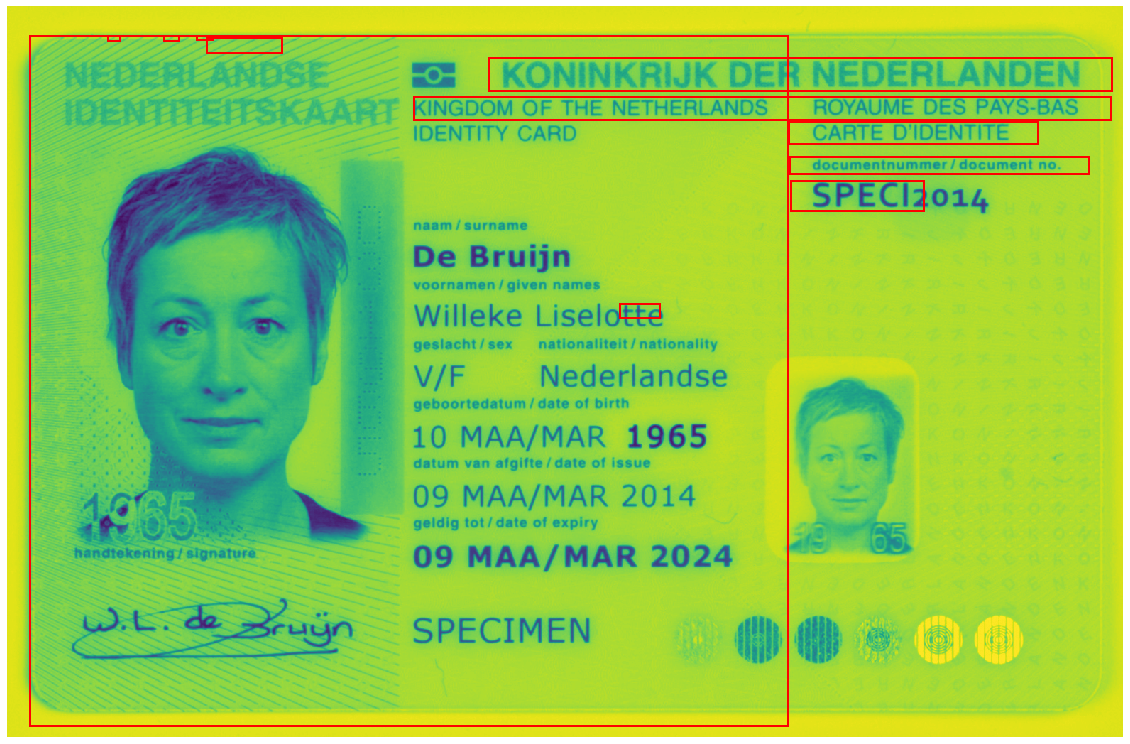

In [38]:
# https://stackoverflow.com/questions/306316/determine-if-two-rectangles-overlap-each-other
import pandas as pd
import time

# minr, minc, maxr, maxc
def is_overlapping(box1, box2):
#     if (RectA.minc < RectB.maxc && RectA.maxc > RectB.minc &&
#      RectA.minr > RectB.maxr && RectA.maxr < RectB.minr )
    if box1[1] < box2[3] and box1[3] > box2[1] and box1[0] < box2[2] and box1[2] > box2[0]:
        return True
    return False

def is_almost_in_line(box1, box2):
    centroid_b1 = [int((box1[0]+box1[2])/2), int((box1[1]+box1[3])/2)]
    centroid_b2 = [int((box2[0]+box2[2])/2), int((box2[1]+box2[3])/2)]
    if (centroid_b2[0]-centroid_b1[0]) == 0:
        return True
    
    angle = (np.arctan(np.abs((centroid_b2[1]-centroid_b1[1])/(centroid_b2[0]-centroid_b1[0])) )*180)/np.pi
    if angle > 80:
        return True
    
    return False

#print(is_overlapping([1,1,3,3],[2,2,4,4]))
def combine_boxes(box1, box2):
    minr = np.min([box1[0],box2[0]])
    minc = np.min([box1[1],box2[1]])
    maxr = np.max([box1[2],box2[2]])
    maxc = np.max([box1[3],box2[3]])
    return [minr, minc, maxr, maxc]

#print(combine_boxes([1,1,3,3],[2,2,4,4]))
#combine overlapping boxes

# sort the bounding_boxes by their distance from Y Axis
# df = pd.DataFrame(bounding_boxes, columns = ["minr", "minc", "maxr", "maxc"])
# df = df.sort_values(["maxr", "maxc"], ascending = (True, True))

# bounding_boxes = df.values

# bounding_boxes = np.array(bounding_boxes)
# bounding_boxes = bounding_boxes[bounding_boxes[:,1].argsort()]

def group_the_bounding_boxes(bounding_boxes):
    stime = time.time()
    number_of_checks = 0
    box_groups = []
    dont_check_anymore = []
    for iindex, box1 in enumerate(bounding_boxes):
        if iindex in dont_check_anymore:
            continue
                
        group_size = 0
        bigger_box = box1
            
        for jindex, box2 in enumerate(bounding_boxes):
            if jindex in dont_check_anymore:
                continue
                
            if jindex == iindex:
                continue
                
            number_of_checks+=1
                    
            if is_overlapping(bigger_box, box2) and is_almost_in_line(bigger_box, box2):
                bigger_box = combine_boxes(bigger_box, box2)
                dont_check_anymore.append(jindex)
                group_size += 1
                
        if group_size > 0:
            # check if this group overlaps any other 
            # and combine it there otherwise make a new box.
            combined_with_existing_box = False
            for kindex, box3 in enumerate(box_groups):
                if is_overlapping(bigger_box, box3):
                    bigger_box = combine_boxes(bigger_box, box3)
                    box_groups[kindex] = bigger_box
                    combined_with_existing_box = True
                    break
                    
            if not combined_with_existing_box:
                box_groups.append(bigger_box)
                
        else:
            dont_check_anymore.append(iindex)
                
    print("number_of_checks:", number_of_checks)
    print("time_taken:", str(time.time() - stime))
    return box_groups


box_groups = group_the_bounding_boxes(bounding_boxes)

fig, ax = plt.subplots(figsize=(20, 16))

# minr, minc, maxr, maxc
for box in box_groups:
    minr = box[0]
    minc = box[1]
    maxr = box[2]
    maxc = box[3]
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
ax.axis("off")
ax.imshow(img)
plt.show() #4914

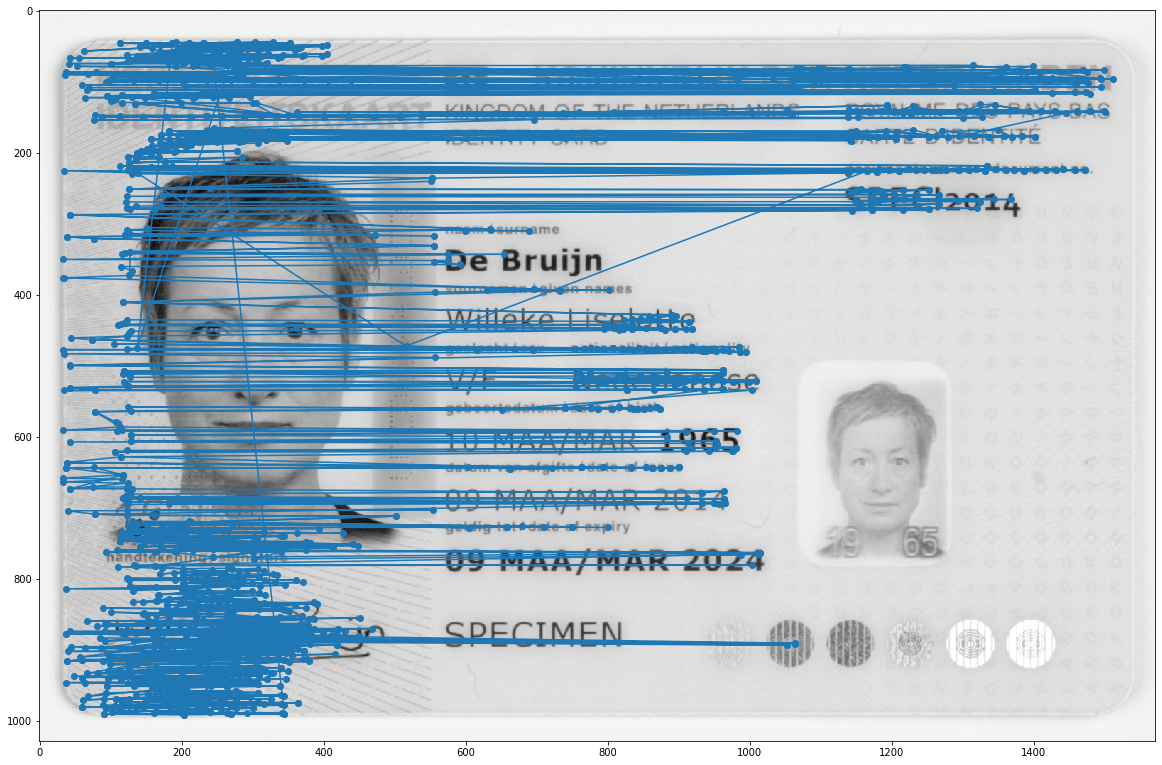

In [39]:
bounding_boxes = np.array(bounding_boxes)
plt.figure(figsize=(20,20))
plt.scatter((bounding_boxes[:,1]+bounding_boxes[:,3])/2,(bounding_boxes[:,0]+bounding_boxes[:,2])/2)
plt.plot((bounding_boxes[:,1]+bounding_boxes[:,3])/2,(bounding_boxes[:,0]+bounding_boxes[:,2])/2)
plt.imshow(img, cmap="gray")

[ 45. 311.  49. 336.]


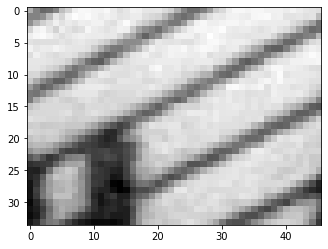

In [40]:
#53.0, 156.0, 93.0, 293.0
print(bounding_boxes[8])
plt.imshow(img[59:93,247:293], cmap="gray")